# Sample Analysis

In [1]:
# importing libraries
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import urllib
import urllib.request
import requests
import matplotlib.pyplot as plt
import json
import time
import seaborn as sns

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [2]:
print('printing packages and versions:\n')

%reload_ext watermark
%watermark -v -p numpy,pandas,geopandas,matplotlib

printing packages and versions:

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy     : 1.23.1
pandas    : 1.4.3
geopandas : 0.11.1
matplotlib: 3.5.2



# Preview Full Data

In [3]:
%%time

path = 'data'
all_files = glob.glob(os.path.join(path, "*.json"))

# concat all counties into one dataframe
df = pd.concat((pd.read_json(file) for file in all_files), ignore_index=True)
# reverse column order
df = df.loc[:, df.columns[::-1]]

# examine data
print('shape of data: {}'.format(df.shape))
df.head()

shape of data: (503873, 81)
CPU times: user 26.8 s, sys: 4.09 s, total: 30.9 s
Wall time: 30.9 s


,id,longitude,latitude,censusBlockGroupFips,censusTract,countyCode,reportedZipCode,reportedCity,propertyState,femaRegion,...,elevatedBuildingIndicator,contentsDeductibleCode,buildingDeductibleCode,crsClassCode,construction,condominiumCoverageTypeCode,cancellationDateOfFloodPolicy,basementEnclosureCrawlspaceType,baseFloodElevation,agricultureStructureIndicator
0,378d7e75-1e2b-4812-96c1-b7ab68868e12,-74.0,40.7,3.606101e+11,3.606101e+10,36061,10011,Currently Unavailable,NY,2.0,...,False,0,0,NaN,False,N,None,NaN,NaN,False
1,33244cc5-c9b3-4477-99de-8984156bd31a,-74.0,40.7,3.606101e+11,3.606101e+10,36061,10012,Currently Unavailable,NY,2.0,...,False,0,0,NaN,False,N,None,2.0,NaN,False
2,3e0fd718-7971-4a6f-8e9b-41f4c121780d,-74.0,40.7,3.606101e+11,3.606101e+10,36061,10011,Currently Unavailable,NY,2.0,...,False,0,0,NaN,False,N,None,NaN,NaN,False
3,d3b936e9-f948-4d20-adb6-fd698faf3417,-73.9,40.8,NaN,NaN,36061,,Currently Unavailable,MS,4.0,...,False,1,1,NaN,False,N,None,NaN,NaN,False
4,994f96b6-eaaa-49d3-b44f-c9e742948dd7,-74.0,40.7,3.606101e+11,3.606101e+10,36061,10001,Currently Unavailable,NY,2.0,...,False,1,0,NaN,False,N,None,2.0,NaN,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503873 entries, 0 to 503872
Data columns (total 81 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   id                                      503873 non-null  object 
 1   longitude                               503873 non-null  float64
 2   latitude                                503873 non-null  float64
 3   censusBlockGroupFips                    501727 non-null  float64
 4   censusTract                             501727 non-null  float64
 5   countyCode                              503873 non-null  int64  
 6   reportedZipCode                         503873 non-null  object 
 7   reportedCity                            503873 non-null  object 
 8   propertyState                           503873 non-null  object 
 9   femaRegion                              503872 non-null  float64
 10  floodZoneCurrent                        3736

# Policies in Force

In [5]:
condition = ((df['policyTerminationDate'] >= '2023-11-01') & (df['policyEffectiveDate'] <= '2023-11-01'))
cols = ['policyTerminationDate', 'policyEffectiveDate', 'policyCount']

pif_df = df.loc[condition, cols]
count = pif_df['policyCount'].sum()
as_of = pif_df['policyEffectiveDate'].max()[:10]

print('policies in force as of {}: {:,}'.format(as_of, count))

policies in force as of 2023-10-31: 59,188


# Sample Plots

In [6]:
df['originalNBYear'] = pd.to_datetime(df['originalNBDate'], errors='coerce').dt.year

original_date = (
    df.groupby(by='originalNBYear')['policyCount']
    .sum()
    .reset_index()
    .astype({'originalNBYear':'int'})
    .sort_values(by='originalNBYear')
)

original_date.head()

,originalNBYear,policyCount
0,1950,6
1,1970,3
2,1975,21
3,1977,15
4,1978,15


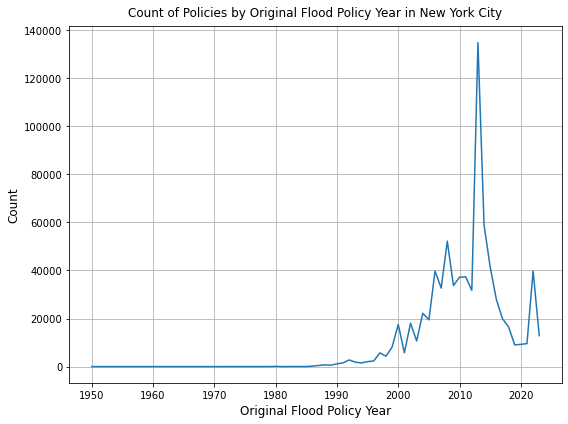

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    x=original_date['originalNBYear'],
    y=original_date['policyCount'],
    color='#1f77b4'
)

label = 'Count of Policies by Original Flood Policy Year in New York City'
plt.title(label, fontsize=12, pad=10)
plt.grid(True)

plt.xlabel('Original Flood Policy Year', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout()

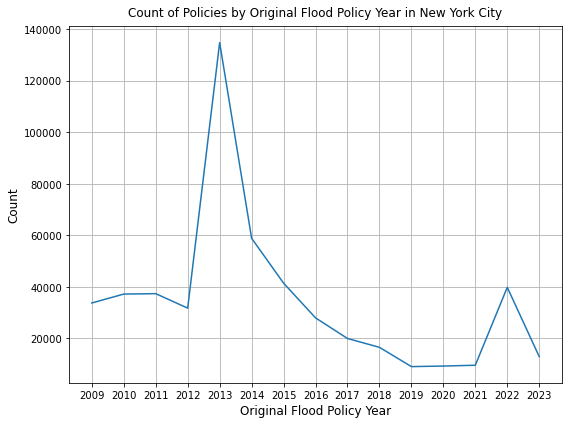

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

data = original_date.loc[original_date['originalNBYear'] >= 2009]

sns.lineplot(
    x=data['originalNBYear'],
    y=data['policyCount'],
    color='#1f77b4'
)

label = 'Count of Policies by Original Flood Policy Year in New York City'
plt.title(label, fontsize=12, pad=10)
plt.grid(True)

ax.set_xticks(np.arange(2009, 2024, 1))
plt.xlabel('Original Flood Policy Year', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout()
plt.savefig('figures/original-policies.png', bbox_inches='tight', dpi=250)

In [9]:
df['policyEffectiveYear'] = pd.to_datetime(df['policyEffectiveDate'], errors='coerce').dt.year

effective_date = (
    df.groupby(by='policyEffectiveYear')['policyCount']
    .sum()
    .reset_index()
    .astype({'policyEffectiveYear':'int'})
    .sort_values(by='policyEffectiveYear')
)

effective_date = effective_date.loc[effective_date['policyEffectiveYear'] < 2024]

effective_date.head()

,policyEffectiveYear,policyCount
0,2009,37539
1,2010,38142
2,2011,39855
3,2012,41366
4,2013,56768


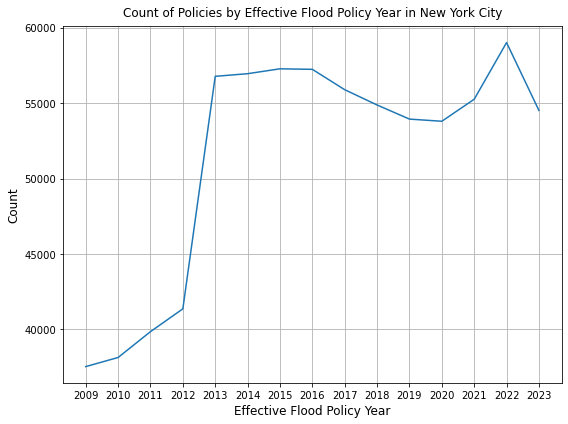

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    x=effective_date['policyEffectiveYear'],
    y=effective_date['policyCount'],
    color='#1f77b4'
)

label = 'Count of Policies by Effective Flood Policy Year in New York City'
plt.title(label, fontsize=12, pad=10)
plt.grid(True)

xticks = np.arange(
    effective_date['policyEffectiveYear'].min(),
    effective_date['policyEffectiveYear'].max() + 1,
    1
)
ax.set_xticks(xticks)

plt.xlabel('Effective Flood Policy Year', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout()
plt.savefig('figures/effective-policies.png', bbox_inches='tight', dpi=250)